In this notebook, I am analyzing the Fitbit dataset for the Capstone Bellabeat project. 
In a previous notebook, I load that dataset into my personal BiqQuery area. Here I will analyze the data from that bigquery dataset.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt 
from google.cloud import bigquery

projectID = 'test-project-306614'
datasetID = 'Fitabase'
client = bigquery.Client(project=projectID, location='US')  ## not sure if the location is needed
dataset = client.get_dataset(datasetID)   
tables = list(client.list_tables(dataset))
for table in tables: print(table.table_id)

dailyActivity
dailyCalories
dailyIntensities
dailySteps
heartrate_seconds
hourlyCalories
hourlyIntensities
hourlySteps
minuteCaloriesNarrow
minuteCaloriesWide
minuteIntensitiesNarrow
minuteIntensitiesWide
minuteMETsNarrow
minuteSleep
minuteStepsNarrow
minuteStepsWide
sleepDay
weightLogInfo


## Daily Activity

I'll first concentrate in daily activity. 

## Daily active 

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


[Text(0.5, 1.0, 'Overall total steps per individual'),
 Text(0.5, 0, 'Sum of total steps'),
 Text(0, 0.5, 'Person ID')]

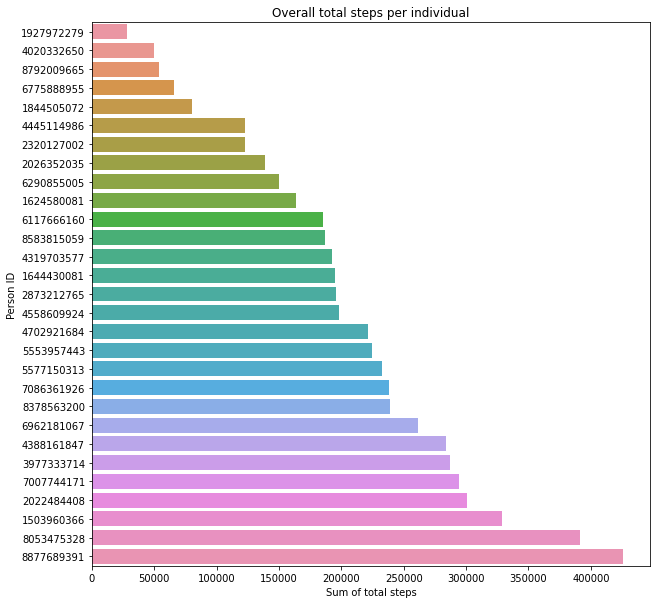

In [2]:
query = f""" 
SELECT 
    CAST(Id AS STRING) AS newId,
    COUNT(ActivityDate) AS countDay,
    SUM(TotalSteps) AS sumTotalSteps,
    SUM(TotalDistance) AS sumTotalDistance,
    SUM(TrackerDistance) AS sumTrackerDistance,
    SUM(LoggedActivitiesDistance) AS sumLoggedActivitiesDistance,
    SUM(VeryActiveDistance) AS sumVeryActiveDistance,
    SUM(ModeratelyActiveDistance) AS sumModeratelyActiveDistance,
    SUM(LightActiveDistance) AS sumLightActiveDistance,
    SUM(SedentaryActiveDistance) AS sumSedentaryActiveDistance,
    SUM(VeryActiveMinutes) AS sumVeryActiveMinutes,
    SUM(FairlyActiveMinutes) AS sumFairlyActiveMinutes,
    SUM(LightlyActiveMinutes) AS sumLightlyActiveMinutes,
    SUM(SedentaryMinutes) AS sumSedentaryMinutes,
    SUM(Calories) AS sumCalories
FROM `{projectID}.{datasetID}.dailyActivity`
--WHERE Id <> 4057192912                      -- removing dirty data
WHERE ActivityDate BETWEEN '2016-04-12' AND '2016-05-07'
GROUP BY Id
HAVING countDay > 20 
ORDER BY sumTotalSteps
"""

query_job = client.query(query)
sumDailyActivity = query_job.to_dataframe()
plt.figure(figsize=(10,10))
sns.barplot(data=sumDailyActivity, 
            x='sumTotalSteps', y='newId',
#             color='gray',
           ).set(
            title='Overall total steps per individual', 
            xlabel='Sum of total steps', ylabel='Person ID'
)

[Text(0.5, 1.0, 'Histogram of total steps for all the individuals'),
 Text(0.5, 0, 'Sum of total steps'),
 Text(0, 0.5, 'Participants')]

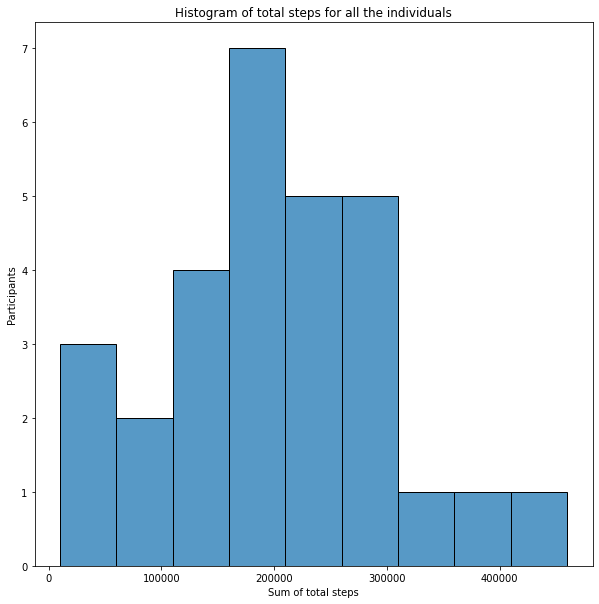

In [3]:
plt.figure(figsize=(10,10))
sns.histplot(data=sumDailyActivity, 
            x='sumTotalSteps', #hue='Id',
            bins = range( 10000, 500000, 50000 )
           ).set(
            title='Histogram of total steps for all the individuals', 
            xlabel='Sum of total steps', ylabel='Participants'
)

[Text(0.5, 1.0, 'Histogram of total steps for all the individuals'),
 Text(0.5, 0, 'Sum of total steps'),
 Text(0, 0.5, 'Participants')]

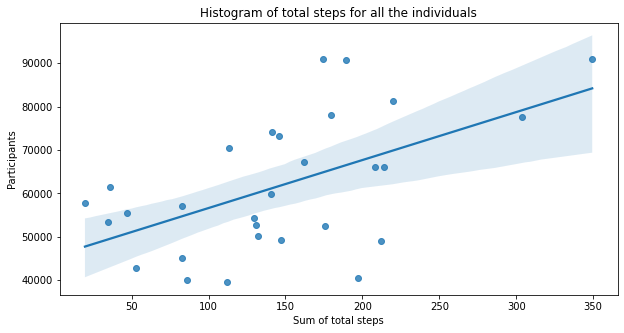

In [4]:
plt.figure(figsize=(10,5))
sns.regplot(data=sumDailyActivity, 
            x='sumTotalDistance', y='sumCalories', #hue='newId'
           ).set(
            title='Histogram of total steps for all the individuals', 
            xlabel='Sum of total steps', ylabel='Participants'
)

Here I am adding all the quantities per Id. This will give me the total number of X (quantity) per participant. I need to divide it further by the `numDayOfWeek` to get averages.

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,Id,DayOfWeek,numDayOfWeek,sumTotalSteps,sumTotalDistance,sumTrackerDistance,sumLoggedActivitiesDistance,sumVeryActiveDistance,sumModeratelyActiveDistance,sumLightActiveDistance,sumSedentaryActiveDistance,sumVeryActiveMinutes,sumFairlyActiveMinutes,sumLightlyActiveMinutes,sumSedentaryMinutes,sumCalories,newId,activeLevel
0,1624580081,Sunday,3,48270,36.040001,36.040001,0.0,24.10,6.62,5.29,0.03,217,103,483,3517,5861,1624580081,Low Active
1,1624580081,Tuesday,4,16005,10.420000,10.420000,0.0,0.00,0.00,10.38,0.03,0,0,523,5237,5603,1624580081,Low Active
2,1624580081,Wednesday,4,22541,14.650000,14.650000,0.0,1.11,1.87,11.66,0.00,17,36,571,5136,5895,1624580081,Low Active
3,1624580081,Thursday,4,20685,13.450000,13.450000,0.0,0.00,0.20,13.20,0.05,0,5,654,5101,5810,1624580081,Low Active
4,1624580081,Friday,4,9653,6.270000,6.270000,0.0,0.00,0.00,6.24,0.01,0,0,547,5213,5559,1624580081,Low Active


[Text(0.5, 1.0, 'Number of total steps for all the participants for each day of the week'),
 Text(0.5, 0, 'Day of the Week'),
 Text(0, 0.5, 'Sum of total steps')]

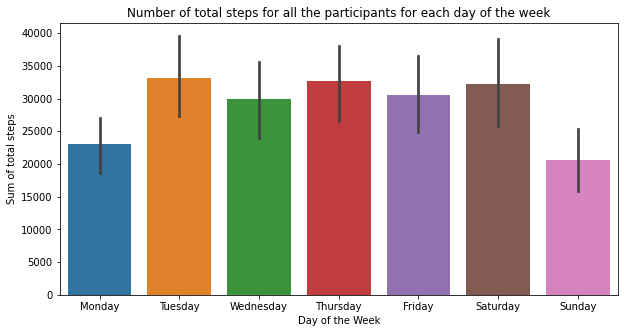

In [5]:
query = f""" 
WITH dailyActivity AS (
    SELECT 
        Id,
        FORMAT_DATE('%A', ActivityDate) AS DayOfWeek,
        COUNT(Id) AS numDayOfWeek,
        SUM(TotalSteps) AS sumTotalSteps,
        SUM(TotalDistance) AS sumTotalDistance,
        SUM(TrackerDistance) AS sumTrackerDistance,
        SUM(LoggedActivitiesDistance) AS sumLoggedActivitiesDistance,
        SUM(VeryActiveDistance) AS sumVeryActiveDistance,
        SUM(ModeratelyActiveDistance) AS sumModeratelyActiveDistance,
        SUM(LightActiveDistance) AS sumLightActiveDistance,
        SUM(SedentaryActiveDistance) AS sumSedentaryActiveDistance,
        SUM(VeryActiveMinutes) AS sumVeryActiveMinutes,
        SUM(FairlyActiveMinutes) AS sumFairlyActiveMinutes,
        SUM(LightlyActiveMinutes) AS sumLightlyActiveMinutes,
        SUM(SedentaryMinutes) AS sumSedentaryMinutes,    
        SUM(Calories) AS sumCalories
    FROM `{projectID}.{datasetID}.dailyActivity`
    WHERE (ActivityDate BETWEEN '2016-04-12' AND '2016-05-07') 
        AND (Id NOT IN (4057192912, 3372868164, 8253242879, 2347167796))
    GROUP BY Id, DayOfWeek
    ORDER BY Id, DayOfWeek
)
SELECT
    dailyActivity.*,
    CAST(dailyActivity.Id AS STRING) AS newId,
    t.activeLevel
FROM dailyActivity
INNER JOIN (
    SELECT 
        Id,
        COUNT(ActivityDate) AS countDay,
        CASE 
            WHEN AVG(TotalSteps) < 5000 THEN 'Sedentary'
            WHEN AVG(TotalSteps) < 7500 THEN 'Low Active'
            WHEN AVG(TotalSteps) < 10000 THEN 'Somewhat Active'
            WHEN AVG(TotalSteps) < 12500 THEN 'Active'
            WHEN AVG(TotalSteps) > 12500 THEN 'Highly Active'
        END AS activeLevel
    FROM `{projectID}.{datasetID}.dailyActivity`
    WHERE ActivityDate BETWEEN '2016-04-12' AND '2016-05-07'
        AND (Id NOT IN (4057192912, 3372868164, 8253242879, 2347167796))
    GROUP BY Id
    --HAVING countDay > 20 
) AS t ON dailyActivity.Id = t.Id
"""

query_job = client.query(query)
dataWeekly = query_job.to_dataframe()
display(dataWeekly.head())
dataWeekly.to_csv('fitabase_dataWeekly.csv', index=False)

plt.figure(figsize=(10,5))
sns.barplot(data=dataWeekly,
             x='DayOfWeek', y='sumTotalSteps',
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
           ).set(title='Number of total steps for all the participants for each day of the week',
                 xlabel="Day of the Week", ylabel='Sum of total steps'
                )

In [6]:
query = f""" 
SELECT 
--    *,
    FORMAT_DATE('%A', ActivityDate) AS DayOfWeek,
    COUNT(*)
FROM `{projectID}.{datasetID}.dailyActivity`
WHERE (ActivityDate BETWEEN '2016-04-12' AND '2016-05-07') 
    AND (Id NOT IN (4057192912, 3372868164, 8253242879, 2347167796))
    AND Id = 1503960366
GROUP BY DayOfWeek
"""
query_job = client.query(query)
data = query_job.to_dataframe()
display(data)

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,DayOfWeek,f0_
0,Sunday,3
1,Friday,4
2,Thursday,4
3,Saturday,4
4,Wednesday,4
5,Tuesday,4
6,Monday,3


[Text(0.5, 1.0, 'Average sedentary active distance for all the participants for each day of the week'),
 Text(0.5, 0, 'Day of the Week'),
 Text(0, 0.5, 'Average sedentary active distance')]

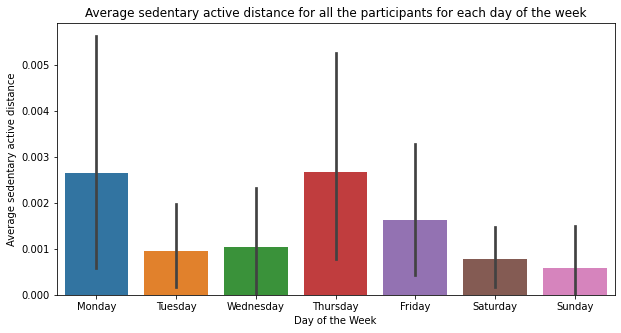

In [7]:
quantity = 'SedentaryActiveDistance'
dataWeekly[f'weighted{quantity}'] = dataWeekly[f'sum{quantity}'] / dataWeekly['numDayOfWeek']
plt.figure(figsize=(10,5))
sns.barplot(data=dataWeekly,
             x='DayOfWeek', y=f'weighted{quantity}',
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
           ).set(title='Average sedentary active distance for all the participants for each day of the week',
                 xlabel="Day of the Week", ylabel='Average sedentary active distance'
                )

In [8]:
query = f""" 
SELECT 
--    CAST(Id AS STRING) AS newId,
    AVG(TotalSteps) AS avgTotalSteps,
    STDDEV(TotalSteps) AS stddevTotalSteps,
    AVG(TotalDistance) AS avgTotalDistance,
    STDDEV(TotalDistance) AS stddevTotalDistance,
    AVG(TrackerDistance) AS avgTrackerDistance,
    STDDEV(TrackerDistance) AS stddevTrackerDistance,
    AVG(LoggedActivitiesDistance) AS avgLoggedActivitiesDistance,
    STDDEV(LoggedActivitiesDistance) AS stddevLoggedActivitiesDistance,
    AVG(VeryActiveDistance) AS avgVeryActiveDistance,
    STDDEV(VeryActiveDistance) AS stddevVeryActiveDistance,
    AVG(ModeratelyActiveDistance) AS avgModeratelyActiveDistance,
    STDDEV(ModeratelyActiveDistance) AS stddevModeratelyActiveDistance,
    AVG(LightActiveDistance) AS avgLightActiveDistance,
    STDDEV(LightActiveDistance) AS stddevLightActiveDistance,
    AVG(SedentaryActiveDistance) AS avgSedentaryActiveDistance,
    STDDEV(SedentaryActiveDistance) AS stddevSedentaryActiveDistance,
    AVG(VeryActiveMinutes) AS avgVeryActiveMinutes,
    STDDEV(VeryActiveMinutes) AS stddevVeryActiveMinutes,
    AVG(FairlyActiveMinutes) AS avgFairlyActiveMinutes,
    STDDEV(FairlyActiveMinutes) AS stddevFairlyActiveMinutes,
    AVG(LightlyActiveMinutes) AS avgLightlyActiveMinutes,
    STDDEV(LightlyActiveMinutes) AS stddevLightlyActiveMinutes,
    AVG(SedentaryMinutes) AS avgSedentaryMinutes,    
    STDDEV(SedentaryMinutes) AS stddevSedentaryMinutes,    
    AVG(Calories) AS avgCalories,
    STDDEV(Calories) AS stddevCalories
FROM `{projectID}.{datasetID}.dailyActivity`
WHERE (ActivityDate BETWEEN '2016-04-12' AND '2016-05-07') 
    AND (Id NOT IN (4057192912, 3372868164, 8253242879, 2347167796))
--GROUP BY Id
ORDER BY avgTotalSteps
"""

query_job = client.query(query)
dataWeekly = query_job.to_dataframe()
display(dataWeekly.transpose())

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,0
avgTotalSteps,7770.755968
stddevTotalSteps,5192.135256
avgTotalDistance,5.598634
stddevTotalDistance,4.019525
avgTrackerDistance,5.580796
stddevTrackerDistance,3.998938
avgLoggedActivitiesDistance,0.122116
stddevLoggedActivitiesDistance,0.668709
avgVeryActiveDistance,1.555345
stddevVeryActiveDistance,2.738024


Adding activity levels according to https://www.medicinenet.com/how_many_steps_a_day_is_considered_active/article.htm

In [9]:
query = f""" 
SELECT 
    Id,
    COUNT(ActivityDate) AS countDay,
    CASE 
        WHEN AVG(TotalSteps) < 5000 THEN 'Sedentary'
        WHEN AVG(TotalSteps) < 7500 THEN 'Low Active'
        WHEN AVG(TotalSteps) < 10000 THEN 'Somewhat Active'
        WHEN AVG(TotalSteps) < 12500 THEN 'Active'
        WHEN AVG(TotalSteps) > 12500 THEN 'Highly Active'
    END AS activeLevel
FROM `{projectID}.{datasetID}.dailyActivity`
WHERE ActivityDate BETWEEN '2016-04-12' AND '2016-05-07'
GROUP BY Id
HAVING countDay > 20 
"""
query_job = client.query(query)
data = query_job.to_dataframe()
display(data.head())
data.to_csv('fitabase_idActiveLevel.csv', index=False)

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,Id,countDay,activeLevel
0,1624580081,26,Low Active
1,1644430081,26,Low Active
2,2022484408,26,Active
3,3977333714,26,Active
4,4319703577,26,Low Active


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,activeLevel,count,avgTotalSteps,avgTotalDistance,avgTrackerDistance,avgLoggedActivitiesDistance,avgVeryActiveDistance,avgModeratelyActiveDistance,avgLightActiveDistance,avgSedentaryActiveDistance,avgVeryActiveMinutes,avgFairlyActiveMinutes,avgLightlyActiveMinutes,avgSedentaryMinutes,avgCalories
0,Sedentary,7,2871.868132,1.955330,1.955330,0.010767,0.240495,0.120989,1.584945,0.000714,4.000000,4.521978,112.582418,1181.351648,2049.390110
1,Low Active,7,6660.527473,4.776593,4.776593,0.000000,0.438352,0.448846,3.582912,0.002692,5.269231,9.928571,211.730769,1035.335165,2261.708791
2,Somewhat Active,7,8520.554945,6.131374,6.131374,0.154745,1.716209,0.670330,3.738242,0.000769,35.653846,17.417582,215.434066,860.565934,2634.472527
3,Active,5,10982.207692,7.807000,7.703538,0.476557,1.981538,1.180231,4.551000,0.001769,26.715385,26.338462,242.576923,885.169231,2357.615385
4,Highly Active,3,14690.076923,11.094103,11.094103,0.000000,6.143974,0.528718,4.402564,0.001410,65.666667,13.230769,207.051282,1040.935897,2792.205128


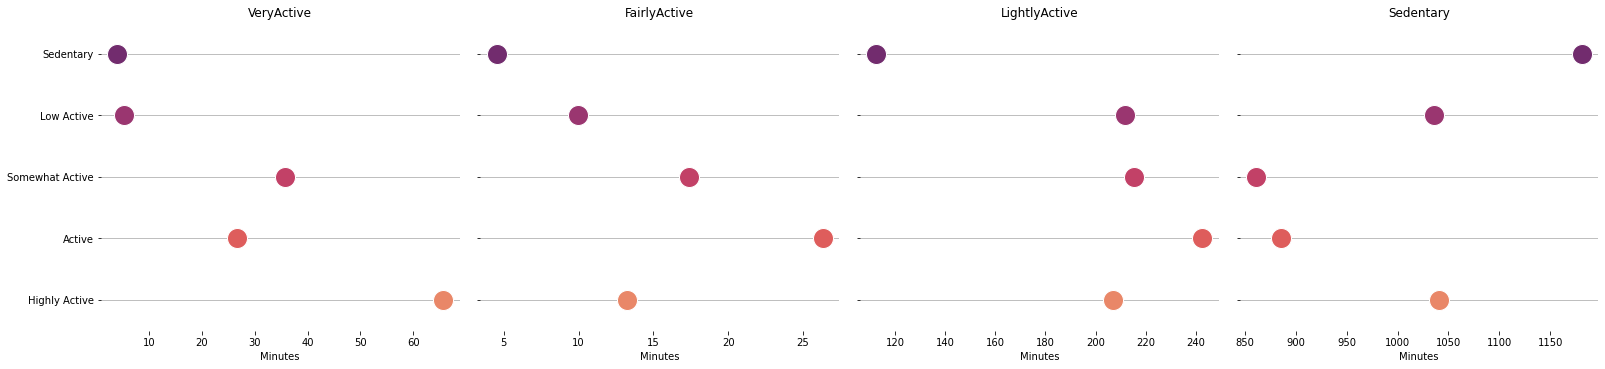

In [10]:
query = f""" 
WITH dailyActivity AS (
    SELECT 
        Id,
        COUNT(dailyActivity.ActivityDate) AS countDay,
        AVG(dailyActivity.TotalSteps) AS avgTotalSteps,
        AVG(dailyActivity.TotalDistance) AS avgTotalDistance,
        AVG(dailyActivity.TrackerDistance) AS avgTrackerDistance,
        AVG(dailyActivity.LoggedActivitiesDistance) AS avgLoggedActivitiesDistance,
        AVG(dailyActivity.VeryActiveDistance) AS avgVeryActiveDistance,
        AVG(dailyActivity.ModeratelyActiveDistance) AS avgModeratelyActiveDistance,
        AVG(dailyActivity.LightActiveDistance) AS avgLightActiveDistance,
        AVG(dailyActivity.SedentaryActiveDistance) AS avgSedentaryActiveDistance,
        AVG(dailyActivity.VeryActiveMinutes) AS avgVeryActiveMinutes,
        AVG(dailyActivity.FairlyActiveMinutes) AS avgFairlyActiveMinutes,
        AVG(dailyActivity.LightlyActiveMinutes) AS avgLightlyActiveMinutes,
        AVG(dailyActivity.SedentaryMinutes) AS avgSedentaryMinutes,    
        AVG(dailyActivity.Calories) AS avgCalories,
    FROM `{projectID}.{datasetID}.dailyActivity` AS dailyActivity
    WHERE ActivityDate BETWEEN '2016-04-12' AND '2016-05-07'
    GROUP BY Id
    HAVING countDay > 20
),
activityLevel AS (
    SELECT
        dailyActivity.*,
        CAST(dailyActivity.Id AS STRING) AS newId,
        t.activeLevel
    FROM dailyActivity
    INNER JOIN (
        SELECT 
            Id,
            COUNT(ActivityDate) AS countDay,
            CASE 
                WHEN AVG(TotalSteps) < 5000 THEN 'Sedentary'
                WHEN AVG(TotalSteps) < 7500 THEN 'Low Active'
                WHEN AVG(TotalSteps) < 10000 THEN 'Somewhat Active'
                WHEN AVG(TotalSteps) < 12500 THEN 'Active'
                WHEN AVG(TotalSteps) > 12500 THEN 'Highly Active'
            END AS activeLevel
        FROM `{projectID}.{datasetID}.dailyActivity`
        WHERE ActivityDate BETWEEN '2016-04-12' AND '2016-05-07'
        GROUP BY Id
        HAVING countDay > 20 
    ) AS t ON dailyActivity.Id = t.Id
)
SELECT 
    activeLevel,
    COUNT(*) AS count,
    AVG(avgTotalSteps) AS avgTotalSteps,
    AVG(avgTotalDistance) AS avgTotalDistance,
    AVG(avgTrackerDistance) AS avgTrackerDistance,
    AVG(avgLoggedActivitiesDistance) AS avgLoggedActivitiesDistance,
    AVG(avgVeryActiveDistance) AS avgVeryActiveDistance,
    AVG(avgModeratelyActiveDistance) AS avgModeratelyActiveDistance,
    AVG(avgLightActiveDistance) AS avgLightActiveDistance,
    AVG(avgSedentaryActiveDistance) AS avgSedentaryActiveDistance,
    AVG(avgVeryActiveMinutes) AS avgVeryActiveMinutes,
    AVG(avgFairlyActiveMinutes) AS avgFairlyActiveMinutes,
    AVG(avgLightlyActiveMinutes) AS avgLightlyActiveMinutes,
    AVG(avgSedentaryMinutes) AS avgSedentaryMinutes,    
    AVG(avgCalories) AS avgCalories,
FROM activityLevel
GROUP BY activeLevel
ORDER BY avgTotalSteps
"""

query_job = client.query(query)
dataActivityLevel = query_job.to_dataframe()
display(dataActivityLevel.head())
dataActivityLevel.to_csv('fitabase_dataActivityLevel.csv', index=False)

# plt.figure(figsize=(10,10))
g = sns.PairGrid(data=dataActivityLevel, 
                 x_vars=['avgVeryActiveMinutes','avgFairlyActiveMinutes','avgLightlyActiveMinutes', 'avgSedentaryMinutes'], 
                 y_vars=['activeLevel'],
                 height=5,
                 aspect=1.1,
)
g.map(sns.stripplot, size=20, orient="h", jitter=False, 
      palette="flare_r", linewidth=1, edgecolor="w")
g.set(xlabel="Minutes", ylabel="")
for ax, title in zip(g.axes.flat, ['VeryActive','FairlyActive','LightlyActive','Sedentary']):
    # Set a different title for each axes
    ax.set(title=title)
    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
sns.despine(left=True, bottom=True)

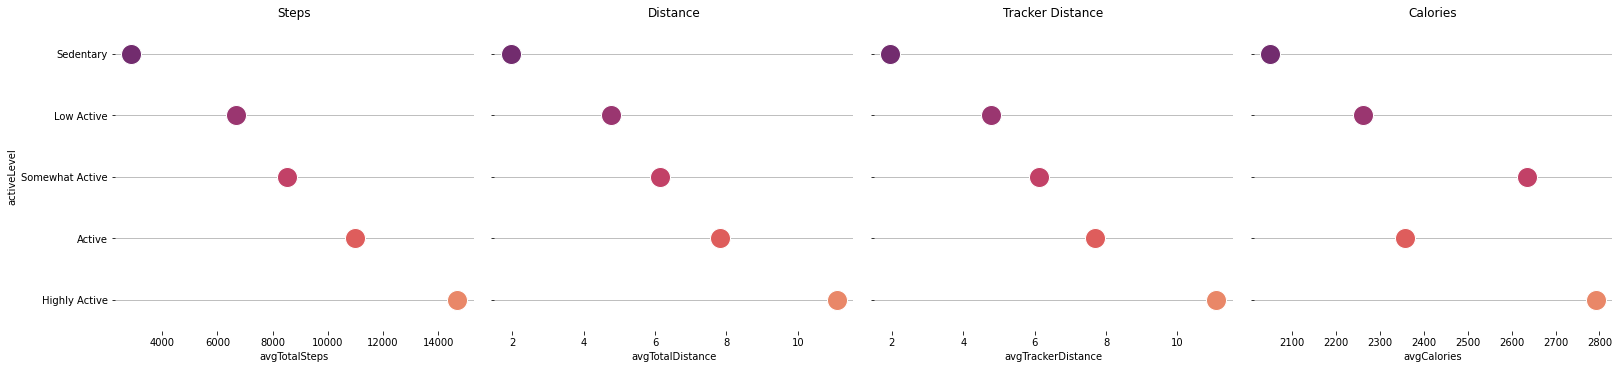

In [11]:
g = sns.PairGrid(data=dataActivityLevel, 
                 x_vars=['avgTotalSteps','avgTotalDistance','avgTrackerDistance', 'avgCalories'], 
                 y_vars=['activeLevel'],
                 height=5,
                 aspect=1.1,
)
g.map(sns.stripplot, size=20, orient="h", jitter=False, 
      palette="flare_r", linewidth=1, edgecolor="w")
# g.set(xlabel="Minutes", ylabel="")
for ax, title in zip(g.axes.flat, ['Steps','Distance','Tracker Distance', 'Calories']):
    # Set a different title for each axes
    ax.set(title=title)
    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
sns.despine(left=True, bottom=True)

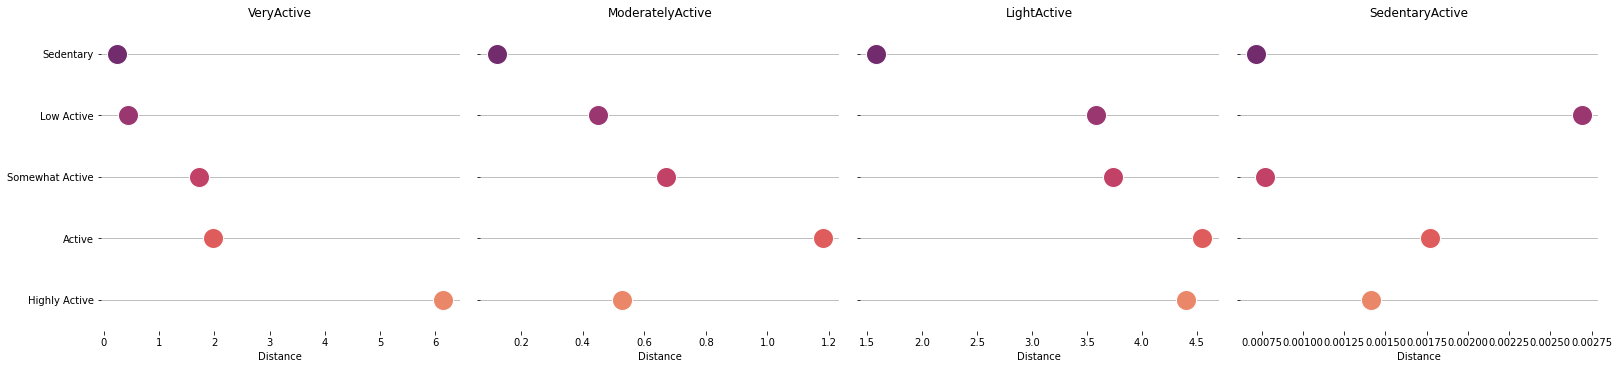

In [12]:
g = sns.PairGrid(data=dataActivityLevel, 
                 x_vars=['avgVeryActiveDistance','avgModeratelyActiveDistance','avgLightActiveDistance', 'avgSedentaryActiveDistance'], 
                 y_vars=['activeLevel'],
                 height=5,
                 aspect=1.1,
)
g.map(sns.stripplot, size=20, orient="h", jitter=False, 
      palette="flare_r", linewidth=1, edgecolor="w")
g.set(xlabel="Distance", ylabel="")
for ax, title in zip(g.axes.flat, ['VeryActive','ModeratelyActive','LightActive', 'SedentaryActive']):
    # Set a different title for each axes
    ax.set(title=title)
    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
sns.despine(left=True, bottom=True)

## Daily sleep 

In [13]:
query = f"""
WITH cleanedSleepDay AS(
    SELECT DISTINCT *
    FROM `{projectID}.{datasetID}.sleepDay`
)
SELECT 
    Id,
    COUNT(*) AS count
FROM cleanedSleepDay
GROUP BY Id
ORDER BY count
"""
query_job = client.query(query)
data = query_job.to_dataframe()
display(data)

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,Id,count
0,2320127002,1
1,7007744171,2
2,1844505072,3
3,6775888955,3
4,8053475328,3
5,1644430081,4
6,1927972279,5
7,4558609924,5
8,4020332650,8
9,2347167796,15


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,newId,sumTotalMinutesAsleep,weightedSumTotalMinutesAsleep,sumTotalTimeInBed,weightedSumTotalTimeInBed,sumTotalTimeAwakeInBed,weightedSumTotalTimeAwakeInBed
0,3977333714,8222,293.642857,12912,461.142857,4690,167.500000
1,1503960366,9007,360.280000,9580,383.200000,573,22.920000
2,4445114986,10785,385.178571,11671,416.821429,886,31.642857
3,4388161847,9204,400.173913,9734,423.217391,530,23.043478
4,4702921684,11272,417.481481,11832,438.222222,560,20.740741
5,5577150313,11232,432.000000,11976,460.615385,744,28.615385
6,8792009665,6535,435.666667,6807,453.800000,272,18.133333
7,8378563200,13799,445.129032,15064,485.935484,1265,40.806452
8,2347167796,6702,446.800000,7370,491.333333,668,44.533333
9,6962181067,13888,448.000000,14450,466.129032,562,18.129032


[Text(0.5, 1.0, 'Weighted sum of the total minutes asleep of the participants'),
 Text(0, 0.5, 'Participant Id'),
 Text(0.5, 0, 'Weighted sum of total minutes asleep')]

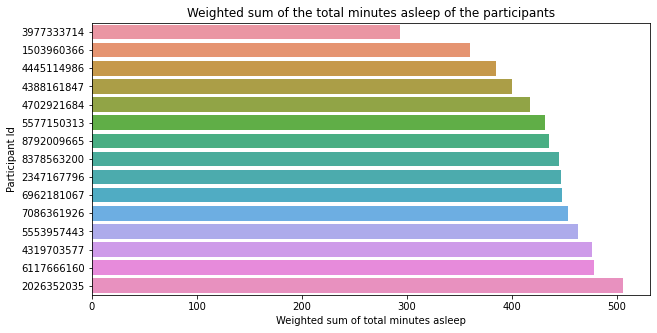

In [14]:
query = f""" 
WITH cleanedSleepDay AS(
    SELECT DISTINCT *
    FROM `{projectID}.{datasetID}.sleepDay`
)
SELECT 
    CAST(Id AS STRING) as newId,
    SUM(TotalMinutesAsleep) as sumTotalMinutesAsleep,
    SUM(TotalMinutesAsleep)/COUNT(*) as weightedSumTotalMinutesAsleep,
    SUM(TotalTimeInBed) as sumTotalTimeInBed,
    SUM(TotalTimeInBed)/COUNT(*) as weightedSumTotalTimeInBed,
    (SUM(TotalTimeInBed) - SUM(TotalMinutesAsleep)) as sumTotalTimeAwakeInBed,
    (SUM(TotalTimeInBed) - SUM(TotalMinutesAsleep))/COUNT(*) as weightedSumTotalTimeAwakeInBed,
FROM cleanedSleepDay
WHERE (Id NOT IN (2320127002, 7007744171, 1844505072, 6775888955, 8053475328, 1644430081, 1927972279, 4558609924, 4020332650))
GROUP BY Id --, TotalSleepRecords
ORDER BY weightedSumTotalMinutesAsleep
"""
query_job = client.query(query)
data = query_job.to_dataframe()
display(data)
plt.figure(figsize=(10,5))
sns.barplot(data=data,
             y='newId', x='weightedSumTotalMinutesAsleep',
           ).set(title='Weighted sum of the total minutes asleep of the participants',
               ylabel='Participant Id', xlabel='Weighted sum of total minutes asleep'
               )

<AxesSubplot:xlabel='weightedSumTotalTimeAwakeInBed', ylabel='newId'>

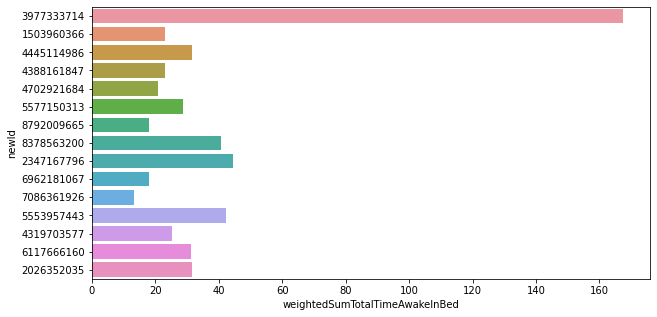

In [15]:
plt.figure(figsize=(10,5))
sns.barplot(data=data,
             y='newId', x='weightedSumTotalTimeAwakeInBed',
           )

In [16]:
query = f""" 
WITH cleanedSleepDay AS(
    SELECT DISTINCT *
    FROM `{projectID}.{datasetID}.sleepDay`
),
weightedTable AS (
    SELECT 
        CAST(Id AS STRING) as newId,
        SUM(TotalMinutesAsleep)/COUNT(*) as weightedSumTotalMinutesAsleep,
        SUM(TotalTimeInBed)/COUNT(*) as weightedSumTotalTimeInBed,
        (SUM(TotalTimeInBed) - SUM(TotalMinutesAsleep))/COUNT(*) as weightedSumTotalTimeAwakeInBed,
    FROM cleanedSleepDay
    WHERE (Id NOT IN (2320127002, 7007744171, 1844505072, 6775888955, 8053475328, 1644430081, 1927972279, 4558609924, 4020332650))
    GROUP BY Id 
    ORDER BY weightedSumTotalMinutesAsleep
)
SELECT 
    AVG(weightedSumTotalMinutesAsleep) AS avgWeightedSumTotalMonutesAsleep,
    STDDEV(weightedSumTotalMinutesAsleep) AS stddevWeightedSumTotalMonutesAsleep,
    AVG(weightedSumTotalTimeInBed) AS avgWeightedSumTotalTimeInBed,
    STDDEV(weightedSumTotalTimeInBed) AS stddevWeightedSumTotalTimeInBed,
    AVG(weightedSumTotalTimeAwakeInBed) AS avgWeightedSumTotalTimeAwakeInBed,
    STDDEV(weightedSumTotalTimeAwakeInBed) AS stddevWeightedSumTotalTimeAwakeInBed,
FROM weightedTable

"""
query_job = client.query(query)
data = query_job.to_dataframe()
display(data.transpose())

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,0
avgWeightedSumTotalMonutesAsleep,429.504773
stddevWeightedSumTotalMonutesAsleep,53.044416
avgWeightedSumTotalTimeInBed,466.831722
stddevWeightedSumTotalTimeInBed,40.596525
avgWeightedSumTotalTimeAwakeInBed,37.326949
stddevWeightedSumTotalTimeAwakeInBed,37.185146


## Weight Information

In [17]:
query = f""" 
WITH cleanedWeightLogInfo AS(
    SELECT DISTINCT *
    FROM `{projectID}.{datasetID}.weightLogInfo`
)
SELECT 
    CAST(Id AS STRING) as newId,
    COUNT(*) as count
--    AVG(WeightKg) AS avgWeightKg,
--    MIN(WeightKg) AS minWeightKg,
--    MAX(WeightKg) AS maxWeightKg,
FROM cleanedWeightLogInfo
GROUP BY Id 
ORDER BY count
"""
query_job = client.query(query)
data = query_job.to_dataframe()
display(data)

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,newId,count
0,5577150313,1
1,1927972279,1
2,4319703577,2
3,1503960366,2
4,2873212765,2
5,4558609924,5
6,8877689391,24
7,6962181067,30


## Correlations between Sleep and Activities

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,Id,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,...,LightlyActiveMinutes,SedentaryMinutes,Calories,Date,DayOfWeek,TotalSleepRecords,TotalTimeInBed,TotalMinutesAsleep,newId,activeLevel
0,1503960366,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,...,328,728,1985,2016-04-12,Tuesday,1,346,327,1503960366,Highly Active
1,1503960366,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,...,209,726,1745,2016-04-15,Friday,1,442,412,1503960366,Highly Active
2,1503960366,9705,6.48,6.48,0.0,3.19,0.78,2.51,0.0,38,...,164,539,1728,2016-04-17,Sunday,1,712,700,1503960366,Highly Active
3,1503960366,15506,9.88,9.88,0.0,3.53,1.32,5.03,0.0,50,...,264,775,2035,2016-04-19,Tuesday,1,320,304,1503960366,Highly Active
4,1503960366,10544,6.68,6.68,0.0,1.96,0.48,4.24,0.0,28,...,205,818,1786,2016-04-20,Wednesday,1,377,360,1503960366,Highly Active


[Text(0.5, 1.0, 'Correlation matrix of the daily features for 15 participants')]

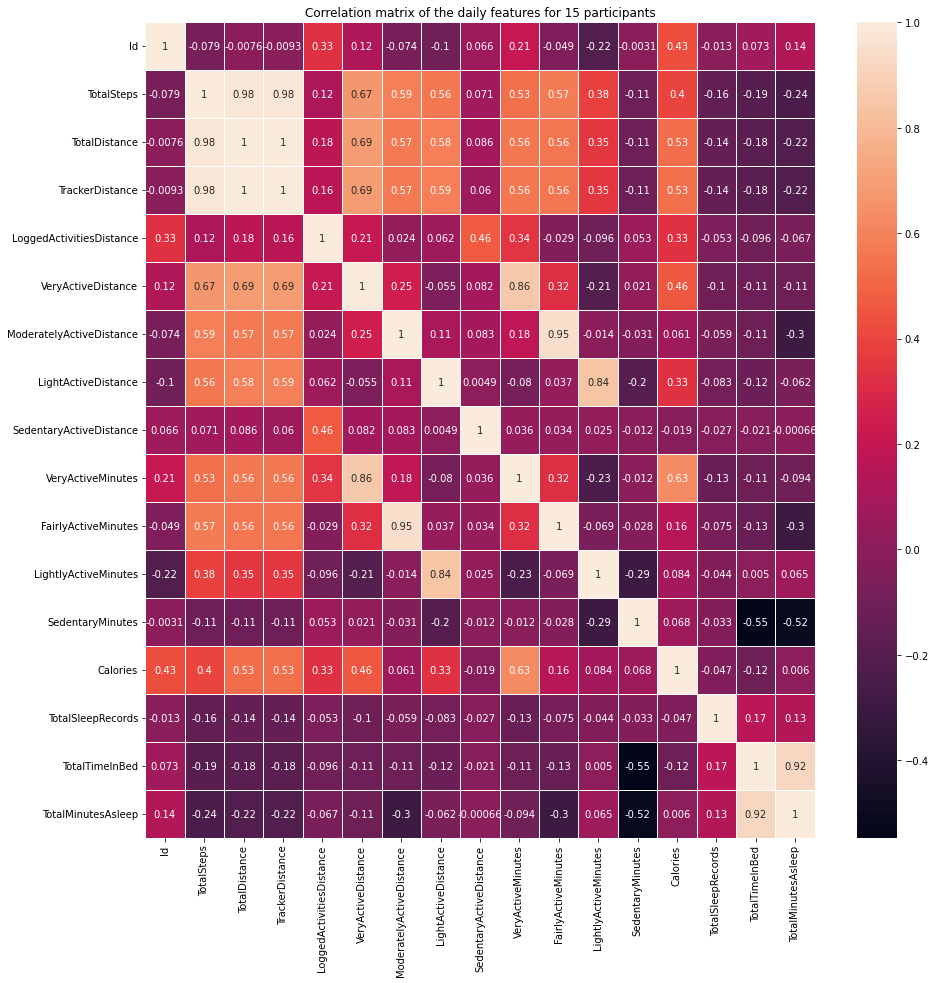

In [18]:
query = f""" 
WITH dailyActivity AS (
    SELECT 
        * EXCEPT(ActivityDate),
        CAST(ActivityDate AS DATE) as Date,
        FORMAT_DATE('%A', ActivityDate) AS DayOfWeek,
    FROM `{projectID}.{datasetID}.dailyActivity`    
),
cleanSleepDay AS (
    SELECT DISTINCT *
    FROM `{projectID}.{datasetID}.sleepDay`    
),
sleepDay AS (
    SELECT 
        * EXCEPT(sleepDay),
        CAST(sleepDay AS DATE) as Date
    FROM cleanSleepDay
),
finalTable AS (
    SELECT 
        dailyActivity.*,
        --COUNT(Id) AS numDayOfWeek,
        sleepDay.TotalSleepRecords,
        sleepDay.TotalTimeInBed,
        sleepDay.TotalMinutesAsleep,
    FROM dailyActivity
    RIGHT JOIN sleepDay
        ON dailyActivity.Id = sleepDay.Id AND dailyActivity.Date = sleepDay.Date
)
SELECT
    finalTable.*, -- EXCEPT(finalTable.Id),
    CAST(finalTable.Id AS STRING) AS newId,
    t.activeLevel
FROM finalTable
INNER JOIN (
    SELECT 
        Id,
        COUNT(ActivityDate) AS countDay,
        CASE 
            WHEN AVG(TotalSteps) < 5000 THEN 'Sedentary'
            WHEN AVG(TotalSteps) < 7500 THEN 'Low Active'
            WHEN AVG(TotalSteps) < 10000 THEN 'Somewhat Active'
            WHEN AVG(TotalSteps) < 12500 THEN 'Active'
            WHEN AVG(TotalSteps) > 12500 THEN 'Highly Active'
        END AS activeLevel
    FROM `{projectID}.{datasetID}.dailyActivity`
    WHERE ActivityDate BETWEEN '2016-04-12' AND '2016-05-07'
    GROUP BY Id
    HAVING countDay > 20 
) AS t ON finalTable.Id = t.Id
WHERE (finalTable.Id NOT IN (2320127002, 7007744171, 1844505072, 6775888955, 8053475328, 1644430081, 1927972279, 4558609924, 4020332650))
"""

query_job = client.query(query)
finalDaylyTable = query_job.to_dataframe()
display(finalDaylyTable.head())
finalDaylyTable.to_csv('fitabase_finalDailyTable.csv', index=False)

plt.figure(figsize=(15,15))
sns.heatmap( data=finalDaylyTable.corr(), linewidths=.5, annot=True 
           ).set(
            title='Correlation matrix of the daily features for 15 participants', 
)

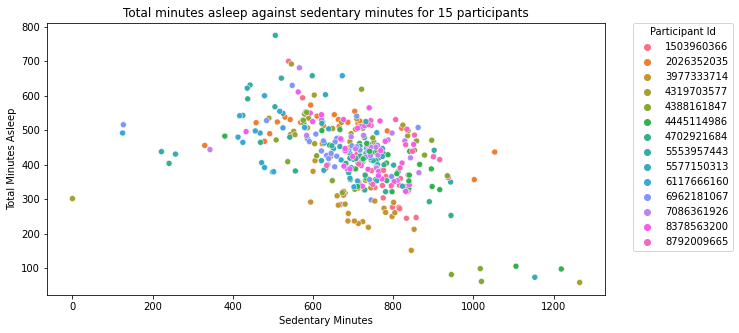

In [19]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=finalDaylyTable, 
            x='SedentaryMinutes', y='TotalMinutesAsleep', hue='newId'
           ).set(
            title='Total minutes asleep against sedentary minutes for 15 participants', 
            xlabel='Sedentary Minutes', ylabel='Total Minutes Asleep'
)
plt.legend(title='Participant Id',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

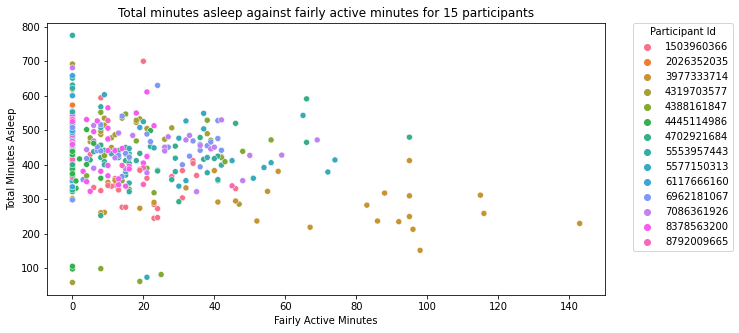

In [20]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=finalDaylyTable, 
            x='FairlyActiveMinutes', y='TotalMinutesAsleep', hue='newId'
           ).set(
            title='Total minutes asleep against fairly active minutes for 15 participants', 
            xlabel='Fairly Active Minutes', ylabel='Total Minutes Asleep'
)
plt.legend(title='Participant Id',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Hourly Analysis

## Hourly Steps

In [21]:

query = f""" 
WITH cleanhourlySteps AS ( SELECT DISTINCT * FROM `{projectID}.{datasetID}.hourlySteps` ),
hourlySteps AS (
    SELECT --*
        CAST(Id AS STRING) AS newId,
        CAST(ActivityHour AS DATE) AS Date,
        CAST(ActivityHour AS TIME) AS Time, 
        StepTotal
    FROM cleanhourlySteps
    WHERE (Id NOT IN (4057192912, 3372868164, 8253242879, 2347167796))
),
tmpTable AS (
    SELECT 
        newId,
        Date,
        COUNT(Time) As count,
    FROM hourlySteps
    WHERE (Date BETWEEN '2016-04-12' AND '2016-05-07') 
    GROUP BY newId, Date
    HAVING count = 24
    --ORDER BY count
)
SELECT 
    newId, 
    COUNT(*) as count
FROM tmpTable
GROUP BY newId
ORDER BY count
"""

query_job = client.query(query)
data = query_job.to_dataframe()
data

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,newId,count
0,6775888955,25
1,7007744171,25
2,8053475328,26
3,1644430081,26
4,4558609924,26
5,4319703577,26
6,2320127002,26
7,1503960366,26
8,8877689391,26
9,4388161847,26


In [22]:

query = f""" 
WITH hourlySteps AS (
    SELECT --*
        CAST(Id AS STRING) AS newId,
        CAST(ActivityHour AS DATE) AS Date,
        CAST(ActivityHour AS TIME) AS Time, 
        FORMAT_DATE('%A', ActivityHour) AS DayOfWeek,
        StepTotal
    FROM `{projectID}.{datasetID}.hourlySteps`
    WHERE (Id NOT IN (4057192912, 3372868164, 8253242879, 2347167796))
)
SELECT --*
    newId, 
    DayOfWeek,
    Time,
    SUM(StepTotal) AS sumStepTotal,
    COUNT(newId) AS numDayOfWeek,
    SUM(StepTotal)/COUNT(newId) AS weightedSumStepTotal,
FROM hourlySteps
WHERE (Date BETWEEN '2016-04-12' AND '2016-05-07') 
GROUP BY newId, DayOfWeek, Time
ORDER BY Time
"""

query_job = client.query(query)
hourlyStepData = query_job.to_dataframe()
display(hourlyStepData.head())
hourlyStepData.to_csv('fitabase_hourlyStepData.csv', index=False)

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,newId,DayOfWeek,Time,sumStepTotal,numDayOfWeek,weightedSumStepTotal
0,8053475328,Tuesday,00:00:00,569,4,142.250000
1,8053475328,Saturday,00:00:00,187,4,46.750000
2,8053475328,Sunday,00:00:00,4,3,1.333333
3,8053475328,Thursday,00:00:00,41,4,10.250000
4,8053475328,Monday,00:00:00,43,3,14.333333


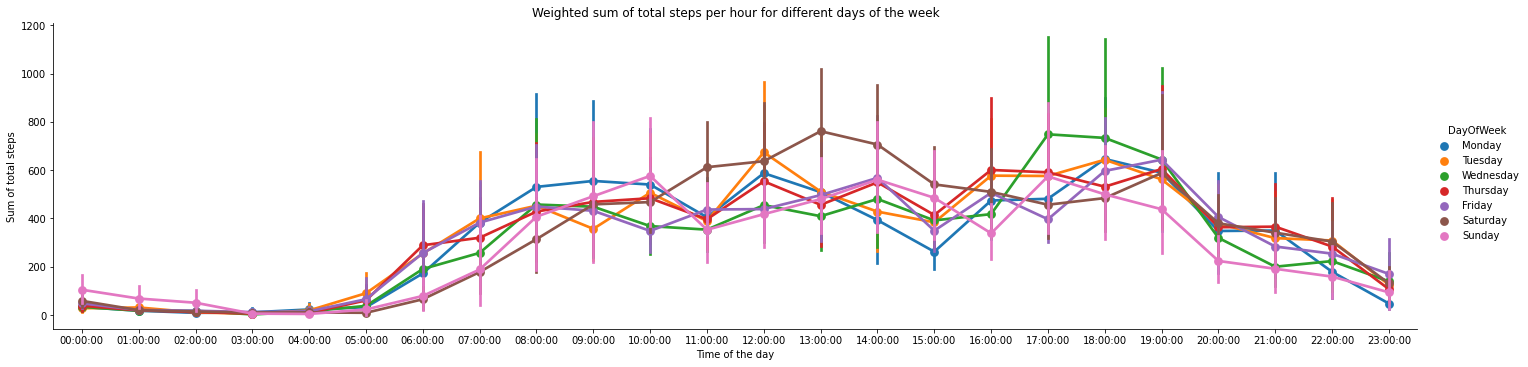

In [23]:
pd.plotting.register_matplotlib_converters()
##plt.figure(figsize=(0,15)) for some reason this does not work
sns.catplot(data=hourlyStepData, 
            x='Time', y='weightedSumStepTotal', 
                hue='DayOfWeek', hue_order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                kind='point', aspect=4, #height=10,
           ).set(
            title='Weighted sum of total steps per hour for different days of the week', 
            ylabel='Sum of total steps', xlabel='Time of the day'
)

## Hourly Calories

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,newId,DayOfWeek,Time,sumCalories,numDayOfWeek,weightedSumCalories
0,8053475328,Saturday,00:00:00,327,4,81.750000
1,8053475328,Sunday,00:00:00,223,3,74.333333
2,8053475328,Monday,00:00:00,226,3,75.333333
3,8053475328,Wednesday,00:00:00,315,4,78.750000
4,8053475328,Thursday,00:00:00,308,4,77.000000


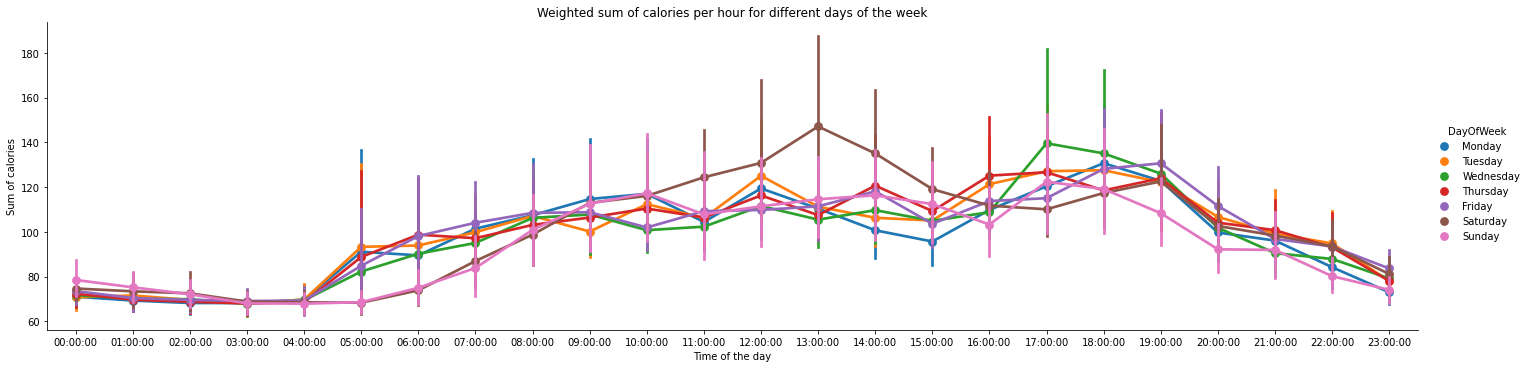

In [24]:

query = f""" 
WITH hourlyCalories AS (
    SELECT --*
        CAST(Id AS STRING) AS newId,
        CAST(ActivityHour AS DATE) AS Date,
        CAST(ActivityHour AS TIME) AS Time, 
        FORMAT_DATE('%A', ActivityHour) AS DayOfWeek,
        Calories
    FROM `{projectID}.{datasetID}.hourlyCalories`
    WHERE (Id NOT IN (4057192912, 3372868164, 8253242879, 2347167796))
)
SELECT --*
    newId, 
    DayOfWeek,
    Time,
    SUM(Calories) AS sumCalories,
    COUNT(newId) AS numDayOfWeek,
    SUM(Calories)/COUNT(newId) AS weightedSumCalories,
FROM hourlyCalories
WHERE (Date BETWEEN '2016-04-12' AND '2016-05-07') 
GROUP BY newId, DayOfWeek, Time
ORDER BY Time
"""

query_job = client.query(query)
hourlyCaloriesData = query_job.to_dataframe()
display(hourlyCaloriesData.head())
hourlyCaloriesData.to_csv('fitabase_hourlyCaloriesData.csv', index=False)

pd.plotting.register_matplotlib_converters()
sns.catplot(data=hourlyCaloriesData, 
            x='Time', y='weightedSumCalories', 
                hue='DayOfWeek', hue_order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                kind='point', aspect=4, #height=10,
           ).set(
            title='Weighted sum of calories per hour for different days of the week', 
            ylabel='Sum of calories', xlabel='Time of the day'
)

## Hourly Intentities

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,newId,DayOfWeek,Time,numDayOfWeek,sumTotalIntensity,weightedSumTotalIntensity,sumAverageIntensity,weightedSumAverageIntensity
0,1503960366,Sunday,00:00:00,3,19,6.333333,0.316667,0.105556
1,1503960366,Tuesday,00:00:00,4,27,6.750000,0.450000,0.112500
2,1503960366,Friday,00:00:00,4,27,6.750000,0.450000,0.112500
3,1503960366,Thursday,00:00:00,4,12,3.000000,0.200000,0.050000
4,1503960366,Monday,00:00:00,3,29,9.666667,0.483333,0.161111


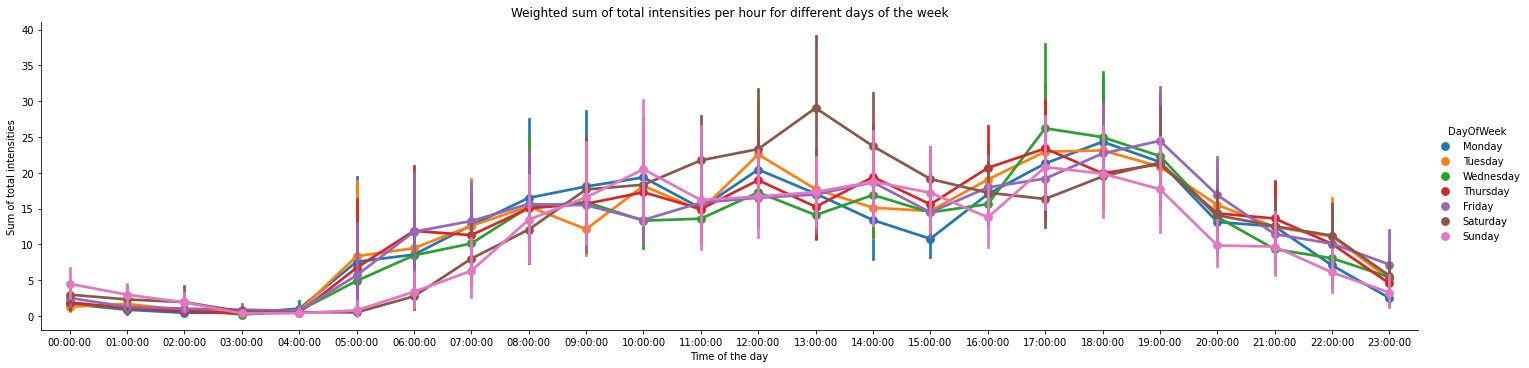

In [25]:

query = f""" 
-- SELECT DISTINCT * FROM `{projectID}.{datasetID}.hourlyIntensities`
WITH hourlyIntensities AS (
    SELECT --*
        CAST(Id AS STRING) AS newId,
        CAST(ActivityHour AS DATE) AS Date,
        CAST(ActivityHour AS TIME) AS Time, 
        FORMAT_DATE('%A', ActivityHour) AS DayOfWeek,
        TotalIntensity,
        AverageIntensity,
    FROM `{projectID}.{datasetID}.hourlyIntensities`
    WHERE (Id NOT IN (4057192912, 3372868164, 8253242879, 2347167796))
)
SELECT --*
    newId, 
    DayOfWeek,
    Time,
    COUNT(newId) AS numDayOfWeek,
    SUM(TotalIntensity) AS sumTotalIntensity,
    SUM(TotalIntensity)/COUNT(newId) AS weightedSumTotalIntensity,
    SUM(AverageIntensity) AS sumAverageIntensity,
    SUM(AverageIntensity)/COUNT(newId) AS weightedSumAverageIntensity,
FROM hourlyIntensities
WHERE (Date BETWEEN '2016-04-12' AND '2016-05-07') 
GROUP BY newId, DayOfWeek, Time
ORDER BY Time
"""

query_job = client.query(query)
hourlyIntensitiesData = query_job.to_dataframe()
display(hourlyIntensitiesData.head())

pd.plotting.register_matplotlib_converters()
sns.catplot(data=hourlyIntensitiesData, 
            x='Time', y='weightedSumTotalIntensity', 
                hue='DayOfWeek', hue_order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                kind='point', aspect=4, #height=10,
           ).set(
            title='Weighted sum of total intensities per hour for different days of the week', 
            ylabel='Sum of total intensities', xlabel='Time of the day'
)

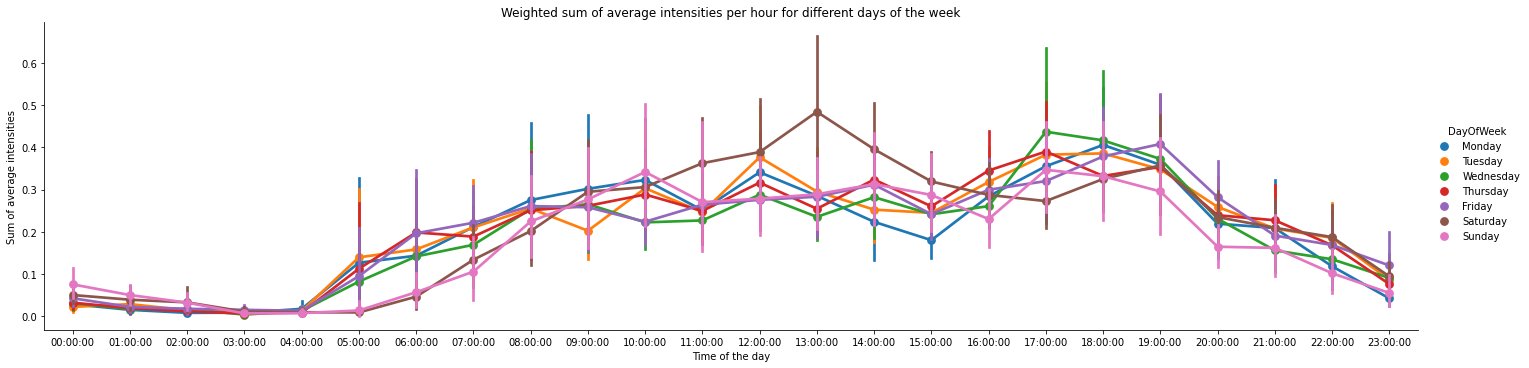

In [26]:
pd.plotting.register_matplotlib_converters()
sns.catplot(data=hourlyIntensitiesData, 
            x='Time', y='weightedSumAverageIntensity', 
                hue='DayOfWeek', hue_order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                kind='point', aspect=4, #height=10,
           ).set(
            title='Weighted sum of average intensities per hour for different days of the week', 
            ylabel='Sum of average intensities', xlabel='Time of the day'
)

# Minute analysis

In [27]:
query = f""" 
WITH cleanMinuteSleep AS (SELECT DISTINCT * FROM `{projectID}.{datasetID}.minuteSleep`),
minuteSleep AS (
    SELECT --*
        CAST(Id AS STRING) AS newId,
        CAST(logId AS STRING) AS newlogId,
        CAST(date AS DATE) AS Date,
        CAST(date AS TIME) AS Time, 
        FORMAT_DATE('%A', date) AS DayOfWeek,
        value,
    FROM cleanMinuteSleep
    WHERE id NOT IN (2320127002, 7007744171)
)
, tmpdata AS (
    SELECT 
        newId,
        Date,
        value,
        COUNT(*) as count,
        --AVG(time) as avgTime
    from minuteSleep
    GROUP BY newId, Date, value
    -- HAVING count<120
    ORDER BY count
)
SELECT 
    value,
    AVG(count) AS avgValue,
    STDDEV(count) AS stddevValue
FROM tmpdata
--WHERE count>10
GROUP BY value
"""

query_job = client.query(query)
data = query_job.to_dataframe()
data

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,value,avgValue,stddevValue
0,1,386.851351,144.033215
1,2,31.800000,39.970160
2,3,5.988095,11.056160


In [28]:
query = f""" 
WITH cleanMinuteSleep AS (SELECT DISTINCT * FROM `{projectID}.{datasetID}.minuteSleep`),
minuteSleep AS (
    SELECT --*
        CAST(Id AS STRING) AS newId,
        CAST(logId AS STRING) AS newlogId,
        CAST(date AS DATE) AS Date,
        CAST(date AS TIME) AS Time, 
        FORMAT_DATE('%A', date) AS DayOfWeek,
        value,
    FROM cleanMinuteSleep
    WHERE id NOT IN (2320127002, 7007744171)
)
, tmpdata AS (
    SELECT 
        DayOfWeek,
        --value,
        newlogId,
        COUNT(*) as count,
        --AVG(value) as avgTime
        CASE
            WHEN (value = 1) THEN 'Asleep'
            WHEN (value = 2) THEN 'Restless'
            WHEN (value = 3) THEN 'Awake'
        END AS sleepState
    from minuteSleep
    GROUP BY DayOfWeek, newlogId, sleepState
)
SELECT 
    DayOfWeek,
    sleepState,
    AVG(count) AS avgValue,
    STDDEV(count) AS stddevValue
FROM tmpdata
--WHERE count>10
GROUP BY DayOfWeek, sleepState
"""

query_job = client.query(query)
dataMinuteSleep = query_job.to_dataframe()
dataMinuteSleep.to_csv('fitabase_dataMinuteSleep.csv', index=False)
dataMinuteSleep

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,DayOfWeek,sleepState,avgValue,stddevValue
0,Tuesday,Asleep,229.894737,135.375346
1,Wednesday,Asleep,243.118644,158.266797
2,Friday,Asleep,259.929412,150.861320
3,Saturday,Asleep,256.247312,176.619873
4,Sunday,Asleep,264.765306,184.765430
5,Thursday,Asleep,248.400000,143.366170
6,Monday,Asleep,207.773196,151.968233
7,Tuesday,Restless,20.572727,33.217509
8,Wednesday,Restless,17.568966,25.307234
9,Friday,Restless,21.666667,31.974599


<Figure size 720x360 with 0 Axes>

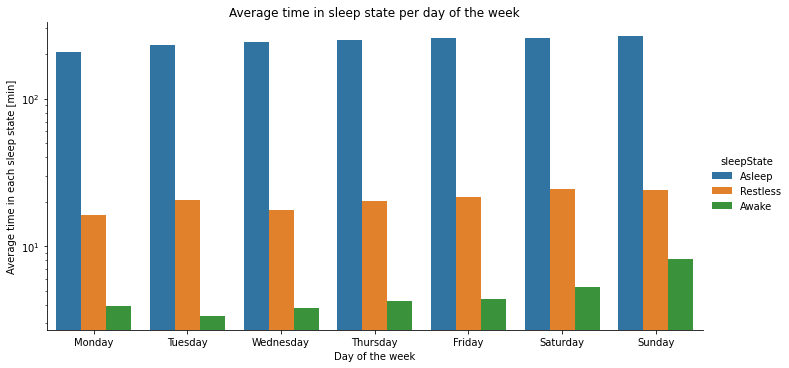

In [29]:
pd.plotting.register_matplotlib_converters()
plt.figure(figsize=(10,5))
g = sns.catplot(data=dataMinuteSleep, 
            x='DayOfWeek', y='avgValue', hue='sleepState',
               order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                kind='bar', 
                aspect=2, #height=10,
           ).set(
            title='Average time in sleep state per day of the week', 
            ylabel='Average time in each sleep state [min]', xlabel='Day of the week'
)
g.set(yscale="log")
